## 3. XGBoost_GSCV

Reference：
- https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/code

## Run name

In [1]:
import time

project_name = 'HomeCreditDefaultRisk'
step_name = 'XGBoost_GSCV'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547


## Important params

## Import PKGs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display

import os
import sys
import gc
import math
import tqdm
import shutil
import zipfile
import pickle
import h5py
# import cv2
from PIL import Image

from tqdm import tqdm
import multiprocessing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

random_num = np.random.randint(10000)
cpu_amount = multiprocessing.cpu_count()

print('cpu_amount: %s' % (cpu_amount - 2))
print('random_num: %s' % random_num)

C:\Users\study\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


cpu_amount: 2
random_num: 3332


In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

import xgboost
from xgboost import plot_importance

## Project folders

In [4]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
figure_folder = os.path.join(cwd, 'figure')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')

application_test_csv_file = os.path.join(input_folder, 'application_test.csv')
application_train_csv_file = os.path.join(input_folder, 'application_train.csv')
bureau_csv_file = os.path.join(input_folder, 'bureau.csv')
bureau_balance_csv_file = os.path.join(input_folder, 'bureau_balance.csv')
credit_card_balance_csv_file = os.path.join(input_folder, 'credit_card_balance.csv')
installments_payments_csv_file = os.path.join(input_folder, 'installments_payments.csv')
POS_CASH_balance_csv_file = os.path.join(input_folder, 'POS_CASH_balance.csv')
previous_application_csv_file = os.path.join(input_folder, 'previous_application.csv')
sample_submission_csv_file = os.path.join(input_folder, 'sample_submission.csv')

print(application_test_csv_file)
print(application_train_csv_file)
print(bureau_csv_file)
print(bureau_balance_csv_file)
print(credit_card_balance_csv_file)
print(installments_payments_csv_file)
print(POS_CASH_balance_csv_file)
print(previous_application_csv_file)
print(sample_submission_csv_file)

D:\bitbucket\kaggle\home-credit-default-risk\input\application_test.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\application_train.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\bureau.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\bureau_balance.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\credit_card_balance.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\installments_payments.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\POS_CASH_balance.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\previous_application.csv
D:\bitbucket\kaggle\home-credit-default-risk\input\sample_submission.csv


## Load data

In [5]:
%%time

train_csv = pd.read_csv(application_train_csv_file)
test_csv = pd.read_csv(application_test_csv_file)
prev_csv = pd.read_csv(previous_application_csv_file)
bureau_csv = pd.read_csv(bureau_csv_file)

sample_submission_csv = pd.read_csv(sample_submission_csv_file)

Wall time: 23.4 s


In [6]:
display(train_csv.head(2))
# display(test_csv.head(2))
# display(prev_csv.head(2))
# display(bureau_csv.head(2))

display(sample_submission_csv.head(2))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5


In [7]:
y_data = train_csv['TARGET']
train_csv = train_csv.drop(columns=['TARGET'])

## Feature

In [8]:
categorical_feats = [
    f for f in train_csv.columns if train_csv[f].dtype == 'object'
]
print(categorical_feats)

for cat in categorical_feats:
    train_csv[cat], indexer = pd.factorize(train_csv[cat])
    test_csv[cat] = indexer.get_indexer(test_csv[cat])

gc.collect()


print(train_csv.columns)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)


### previous_application

In [9]:
# Count
count_prev = prev_csv[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_csv['SK_ID_PREV'] = prev_csv['SK_ID_CURR'].map(count_prev['SK_ID_PREV'])
# Average
avg_prev = prev_csv.groupby('SK_ID_CURR').mean()
avg_prev.columns = ['prev_app_' + f_ for f_ in avg_prev.columns]

# del prev_csv, count_prev
# gc.collect()

### bureau

In [10]:
bureau_cat_features = [
    f_ for f_ in bureau_csv.columns if bureau_csv[f_].dtype == 'object'
]
for f_ in bureau_cat_features:
    # buro[f_], _ = pd.factorize(buro[f_])
    bureau_csv = pd.concat([bureau_csv, pd.get_dummies(bureau_csv[f_], prefix=f_)], axis=1)

avg_bureau = bureau_csv.groupby('SK_ID_CURR').mean()
avg_bureau['buro_count'] = bureau_csv[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_bureau['SK_ID_BUREAU']

avg_bureau.columns = ['bureau_' + f_ for f_ in avg_bureau.columns]
# del avg_bureau
# gc.collect()

### Merge

In [11]:
train_csv = train_csv.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
train_csv = train_csv.merge(right=avg_bureau.reset_index(), how='left', on='SK_ID_CURR')

test_csv = test_csv.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test_csv = test_csv.merge(right=avg_bureau.reset_index(), how='left', on='SK_ID_CURR')

## Get feature

In [12]:
id_data = train_csv['SK_ID_CURR']
id_test = test_csv['SK_ID_CURR']
x_data = train_csv.drop(columns=['SK_ID_CURR', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1'])
x_test = test_csv.drop(columns=['SK_ID_CURR', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1'])

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.05, random_state=random_num, shuffle=False)

# x_train, y_train = shuffle(x_train, y_train, random_state=random_num)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(292135, 173)
(292135,)
(15376, 173)
(15376,)


## Train

In [14]:
%%time
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

clf = xgb.XGBClassifier(
    max_depth=4, 
    learning_rate=0.1, 
    n_estimators=50, 
    silent=False, 
    objective='gpu:binary:logistic', 
    booster='gbtree', 
    n_jobs=cpu_amount, 
    nthread=None, 
    gamma=0, 
    min_child_weight=1, 
    max_delta_step=0, 
    subsample=0.5, 
    colsample_bytree=0.1, 
    colsample_bylevel=0.1, 
    reg_alpha=1, 
    reg_lambda=2, 
    scale_pos_weight=10, 
    base_score=0.5, 
    random_state=random_num, 
    seed=None, 
    missing=None,
    # booster params
    num_boost_round=50,
    early_stopping_rounds=30,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric=['auc'],
)

parameters = {
#     'max_depth': [3, 4, 5],
#     'n_estimators': [1000, 2000, 3000, 5000]
#     'subsample': [0.5, 1], 
#     'colsample_bytree': [0.5, 1], 
#     'reg_alpha':[0, 1, 5], 
#     'reg_lambda':[1, 2, 8],
#     'scale_pos_weight': [1, 10, 80, 100, 120, 200]
}

grid_search = GridSearchCV(clf, parameters, verbose=2, cv=3, scoring='roc_auc')
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ................................................. , total=  18.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=  18.3s
[CV]  ................................................................
[CV] ................................................. , total=  18.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


Wall time: 1min 31s


In [15]:
%%time

print('*' * 80)
y_train_proba = grid_search.predict_proba(x_train)
print(y_train.shape)
print(y_train_proba.shape)
print(y_train_proba[:10])
y_train_pred = (y_train_proba[:, 1]>=0.5).astype(int)
acc_train = accuracy_score(y_train, y_train_pred)
roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

# y_train_pred = grid_search.predict(x_train)
# acc_train = accuracy_score(y_train, y_train_pred)
# roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
# print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

y_val_proba = grid_search.predict_proba(x_val)
print(y_val.shape)
print(y_val_proba.shape)
print(y_val_proba[:10])
y_val_pred = (y_val_proba[:, 1]>=0.5).astype(int)
print(y_val.shape)
print(y_val_pred.shape)
acc_val = accuracy_score(y_val, y_val_pred)
roc_val = roc_auc_score(y_val, y_val_proba[:, 1])
print('acc_val:   %.4f \t roc_val:   %.4f' % (acc_val, roc_val))

********************************************************************************
(292135,)
(292135, 2)
[[0.47639954 0.52360046]
 [0.64541185 0.35458815]
 [0.5277294  0.47227058]
 [0.41954976 0.58045024]
 [0.56859577 0.4314042 ]
 [0.57699656 0.42300344]
 [0.63173485 0.36826518]
 [0.564836   0.435164  ]
 [0.60795283 0.39204717]
 [0.4527188  0.5472812 ]]
acc_train: 0.7266 	 roc_train: 0.6546
(15376,)
(15376, 2)
[[0.48137742 0.5186226 ]
 [0.48184305 0.51815695]
 [0.54634756 0.45365244]
 [0.43574744 0.56425256]
 [0.7453877  0.25461233]
 [0.57936406 0.4206359 ]
 [0.54699695 0.45300305]
 [0.43425727 0.56574273]
 [0.67630315 0.32369682]
 [0.45929646 0.54070354]]
(15376,)
(15376,)
acc_val:   0.7251 	 roc_val:   0.6465
Wall time: 3.29 s


In [16]:
print(grid_search.cv_results_)
print('*' * 60)
print(grid_search.grid_scores_ )
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.scorer_)
print('*' * 60)
print(type(grid_search.best_estimator_))
print(dir(grid_search.best_estimator_))

{'mean_fit_time': array([17.53284701]), 'std_fit_time': array([0.17255087]), 'mean_score_time': array([1.15499592]), 'std_score_time': array([0.05849113]), 'params': [{}], 'split0_test_score': array([0.65471795]), 'split1_test_score': array([0.65232267]), 'split2_test_score': array([0.64428002]), 'mean_test_score': array([0.65044023]), 'std_test_score': array([0.00446433]), 'rank_test_score': array([1]), 'split0_train_score': array([0.6643683]), 'split1_train_score': array([0.66361929]), 'split2_train_score': array([0.65632949]), 'mean_train_score': array([0.66143903]), 'std_train_score': array([0.0036259])}
************************************************************
[mean: 0.65044, std: 0.00446, params: {}]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
       colsample_bytree=0.1, early_stopping_rounds=30, eval_metric=['auc'],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=4,


In [17]:
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,17.532847,1.154996,0.65044,0.661439,{},1,0.654718,0.664368,0.652323,0.663619,0.64428,0.656329,0.172551,0.058491,0.004464,0.003626


In [18]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(20, 20), dpi=1000)
plot_tree(grid_search.best_estimator_, ax=ax, num_trees=0)
tree_img_file = os.path.join(figure_folder, '%s_plot_tree.png' % run_name)
print(tree_img_file)
fig.savefig(tree_img_file)

D:\bitbucket\kaggle\home-credit-default-risk\figure\HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_plot_tree.png


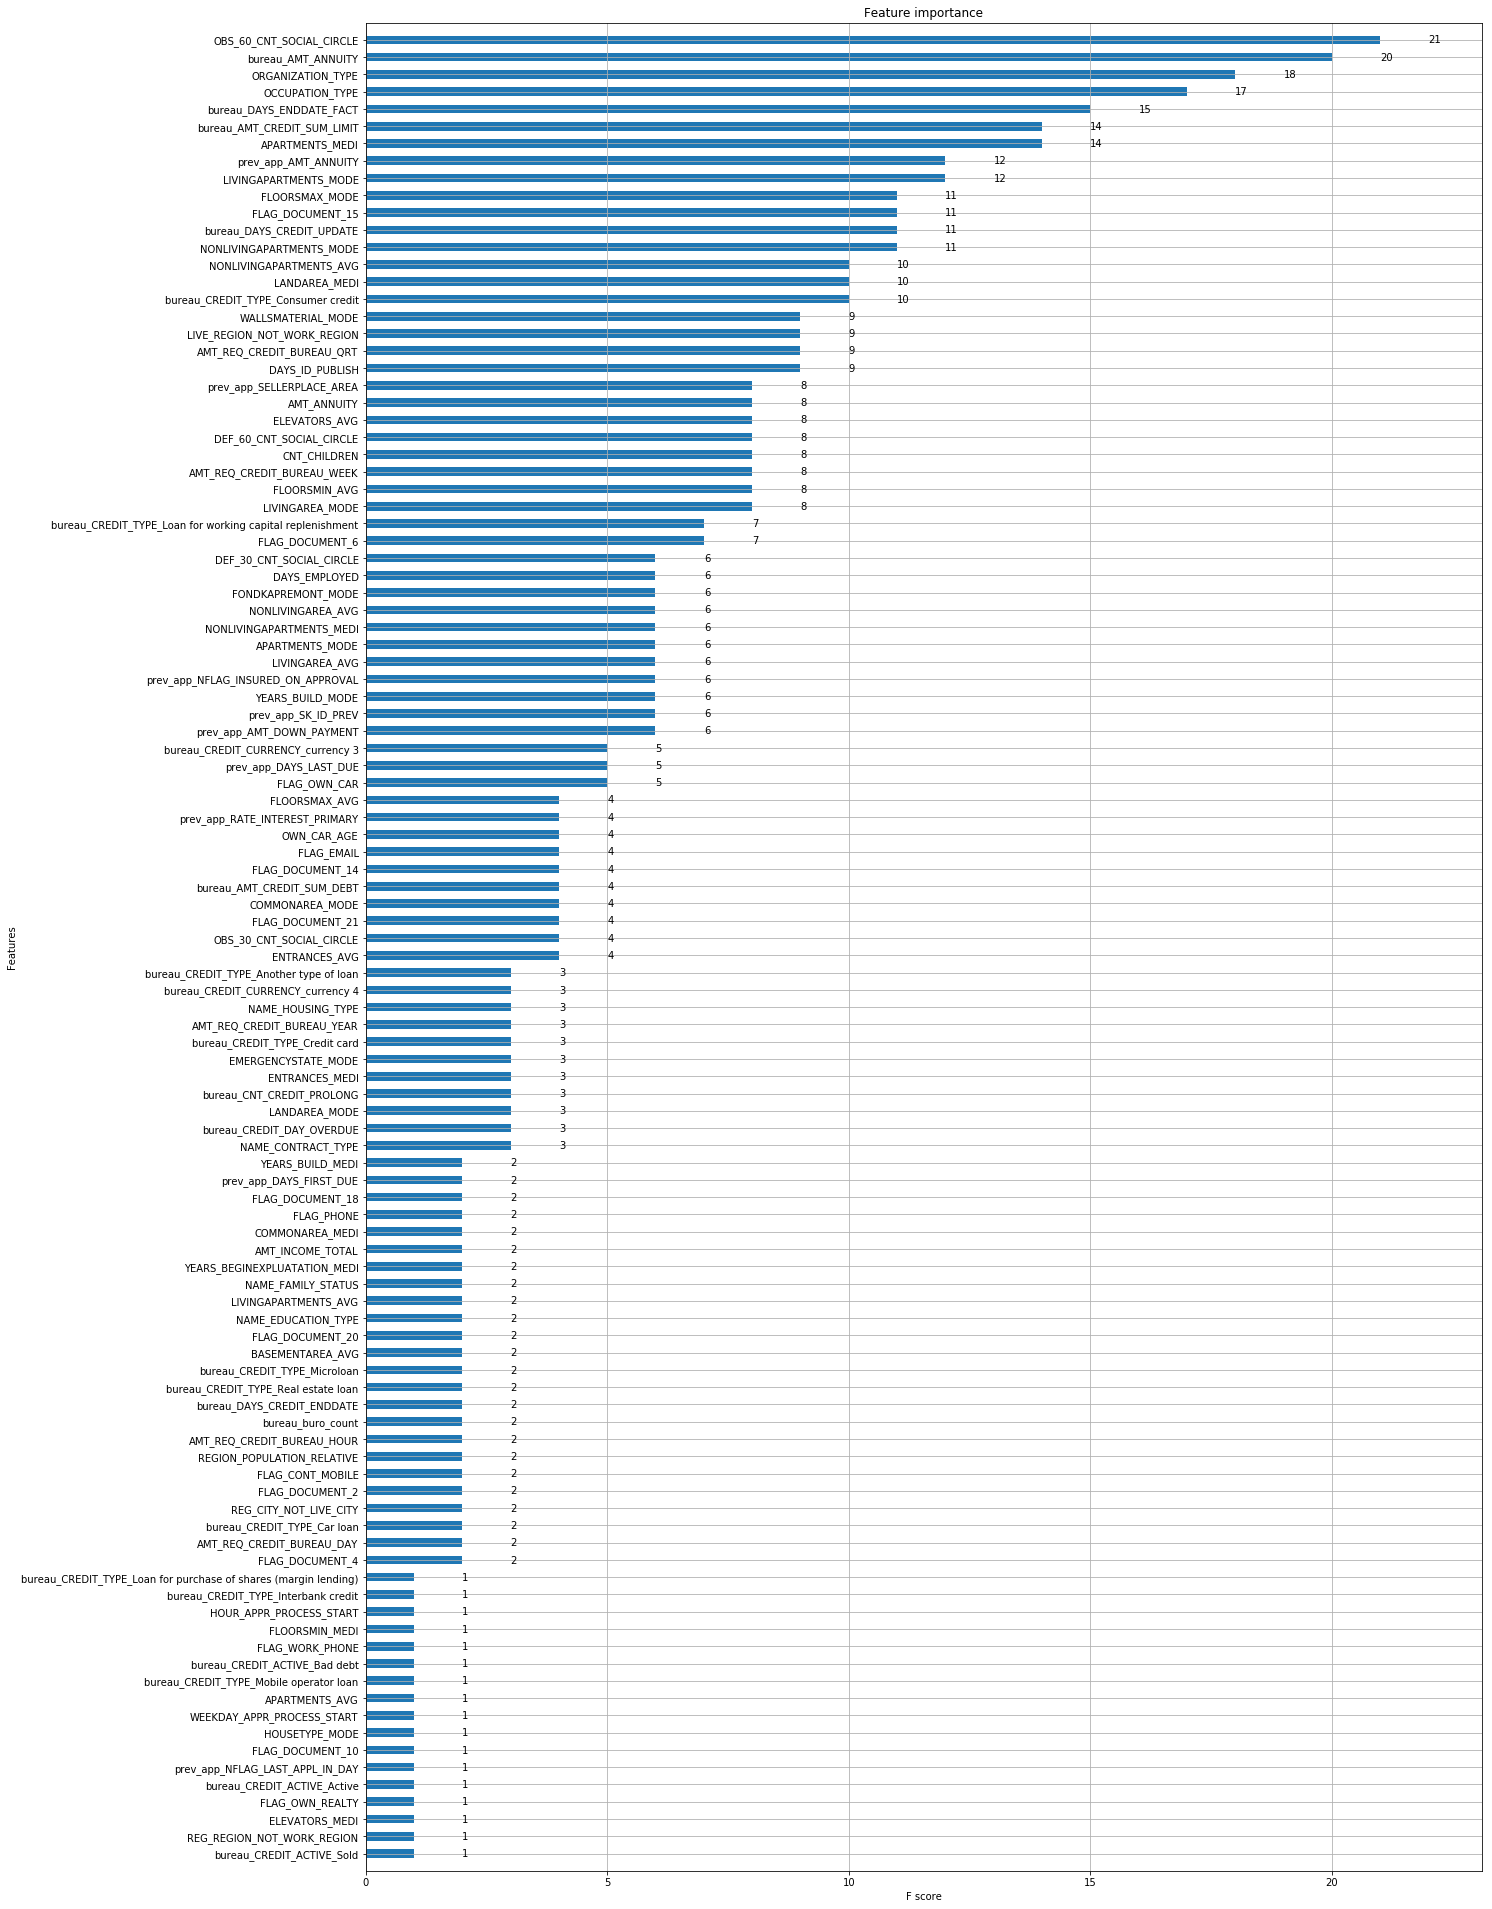

D:\bitbucket\kaggle\home-credit-default-risk\figure\HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_plot_importance.png


In [19]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20,int(x_train.shape[1]/5)))
xgb.plot_importance(grid_search.best_estimator_, height=0.5, ax=ax, max_num_features=300)
plt.show()
tree_img_file = os.path.join(figure_folder, '%s_plot_importance.png' % run_name)
print(tree_img_file)
fig.savefig(tree_img_file)
importance_score = grid_search.best_estimator_.get_booster().get_fscore()

# for item in importance_score.items():
#     print(item)

In [20]:
importance_table = pd.DataFrame(data={'key': list(importance_score.keys()), 'importance_score': list(importance_score.values())})
display(importance_table.head(2))
importance_table=importance_table.sort_values(by='importance_score', ascending=False)
display(importance_table)

,importance_score,key
0,1,bureau_CREDIT_ACTIVE_Sold
1,6,prev_app_AMT_DOWN_PAYMENT


,importance_score,key
59,21,OBS_60_CNT_SOCIAL_CIRCLE
5,20,bureau_AMT_ANNUITY
7,18,ORGANIZATION_TYPE
26,17,OCCUPATION_TYPE
12,15,bureau_DAYS_ENDDATE_FACT
35,14,bureau_AMT_CREDIT_SUM_LIMIT
23,14,APARTMENTS_MEDI
50,12,prev_app_AMT_ANNUITY
10,12,LIVINGAPARTMENTS_MODE
94,11,FLOORSMAX_MODE


## Predict

In [21]:
run_name_acc = run_name + '_' + str(int(roc_val*10000)).zfill(4)
print(run_name_acc)

HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_6465


In [22]:
y_test_proba = grid_search.predict_proba(x_test)

print(y_test_proba.shape)
print(y_test_proba[:10])

(48744, 2)
[[0.5586791  0.4413209 ]
 [0.45382494 0.54617506]
 [0.64705616 0.35294384]
 [0.6306555  0.36934447]
 [0.44170344 0.55829656]
 [0.63866466 0.36133534]
 [0.5727956  0.4272044 ]
 [0.49082047 0.50917953]
 [0.5321853  0.46781468]
 [0.48759705 0.51240295]]


In [23]:
def save_proba(y_val_proba, y_val, y_test_proba, id_test, file_name):
    print(id_test[:5])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: %s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_val_proba', data=y_val_proba)
        h.create_dataset('y_val', data=y_val)
        h.create_dataset('y_test_proba', data=y_test_proba)
        h.create_dataset('id_test', data=id_test)
    print('File saved:   %s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_val_proba = np.array(h['y_val_proba'])
        y_val = np.array(h['y_val'])
        y_test_proba = np.array(h['y_test_proba'])
        id_test = np.array(h['id_test'])
    print('File loaded:  %s' % file_name)
    print(id_test[:5])
    
    return y_val_proba, y_val, y_test_proba, id_test


y_proba_file = os.path.join(model_folder, 'proba_%s.p' % run_name_acc)
save_proba(
    y_val_proba[:, 1], 
    y_val, 
    y_test_proba[:, 1], 
    id_test,
    y_proba_file
)
y_val_proba_true, y_val, y_test_proba_true, id_test = load_proba(y_proba_file)

print(y_val_proba_true.shape)
print(y_val.shape)
print(y_test_proba_true.shape)
print(len(id_test))

0    100001
1    100005
2    100013
3    100028
4    100038
Name: SK_ID_CURR, dtype: int64
File saved:   D:\bitbucket\kaggle\home-credit-default-risk\model\proba_HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_6465.p
File loaded:  D:\bitbucket\kaggle\home-credit-default-risk\model\proba_HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_6465.p
[100001 100005 100013 100028 100038]
(15376,)
(15376,)
(48744,)
48744


In [24]:
# %%time
submission_csv_file = os.path.join(output_folder, 'pred_%s.csv' % run_name_acc)
print(submission_csv_file)
submission_csv = pd.DataFrame({ 'SK_ID_CURR': id_test , 'TARGET': y_test_proba_true })
submission_csv.to_csv(submission_csv_file, index = False)
display(submission_csv.head())

D:\bitbucket\kaggle\home-credit-default-risk\output\pred_HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_6465.csv


,SK_ID_CURR,TARGET
0,100001,0.441321
1,100005,0.546175
2,100013,0.352944
3,100028,0.369344
4,100038,0.558297


In [25]:
print('Time cost: %.2f s' % (time.time() - t0))

print('random_num: ', random_num)
print(run_name_acc)
print('Done!')

Time cost: 63810.42 s
random_num:  3332
HomeCreditDefaultRisk_XGBoost_GSCV_20180601_005547_6465
Done!
